Imports and fetching data

In [28]:
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from matplotlib import pyplot as plt
import numpy as np

X, y = fetch_openml(name='mnist_784',return_X_y=True, as_frame=False)

Visualising sampled images and labels

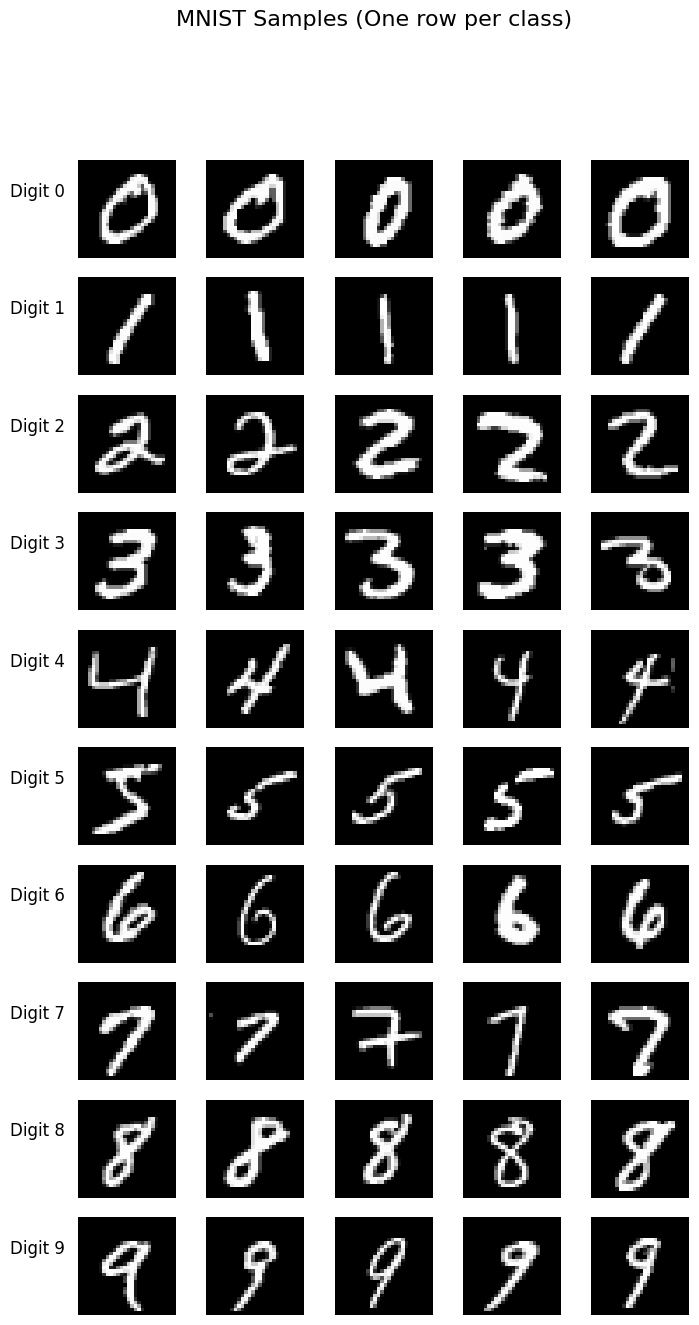

In [29]:
fig, axes = plt.subplots(10, 5, figsize=(8, 15))

# y comes as strings from openml ('0', '1', ...)
classes = sorted(np.unique(y))

for i, cls in enumerate(classes):
    # Get indices of all images belonging to this class
    idxs = np.where(y == cls)[0]
    
    # Take the first 5 examples
    for j in range(5):
        ax = axes[i, j]
        if j < len(idxs):
            # Reshape flat 784 vector to 28x28 image
            img = X[idxs[j]].reshape(28, 28)
            ax.imshow(img, cmap='gray')
        ax.axis('off')
        # Add label to the left-most image of each row
        if j == 0:
            ax.text(-20, 10, f"Digit {cls}", fontsize=12)
plt.suptitle("MNIST Samples (One row per class)", fontsize=16)
plt.show()

Scaling the data to 0-1 and performing PCA

In [30]:
X_scaled = X / 255.0 # this improves numerical stability and ensures that the "brightness" of a pixel is treated consistently across the image
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=5)

pca = PCA(n_components=80)
X_train_reduced = pca.fit_transform(X_train)
X_test_reduced = pca.transform(X_test)

### K-Means clustering

#### Choosing hyperparameters
To systematically find the best combination of hyperparameters for K-Means, I perform a Grid Search.\
The MNIST dataset has ground truth labels, so I can use ARI and homogeneity metrics to evaluate the model created with each set of hyperparameters\
I have explored ... hyperparameters. This is because...

In [31]:
from sklearn.cluster import KMeans


# 1. Define the grid of hyperparameters you want to explore
param_grid = {
    # MNIST has 10 digits, but handwriting styles vary. 
    # Optimal K is often higher than 10 to capture different styles of '7', '1', etc.
    'n_clusters': [10, 15, 20, 25, 30], 
    
    # 'k-means++' usually converges faster, 'random' is the baseline
    # 'init': ['k-means++', 'random'], 
    'init': ['k-means++'],
    
    # # Number of times k-means will run with different seeds. Higher = better chance of global optimum.
    # 'n_init': [10, 20], 
    'n_init': [20],
    
    # # Max iterations for a single run
    # 'max_iter': [300, 500],
    'max_iter': [300],
    
    # # Tolerance to declare convergence (smaller = more precise but slower)
    # 'tol': [1e-4, 1e-3]
    'tol': [1e-40]
}

results = []

# 2. Iterate through every combination
# We use a subset for scoring speed, but fit on the whole train set
sample_size = 5000 
X_test_sample = X_test_reduced[:sample_size] # Use test set or subset of train for validation
y_test_sample = y_test[:sample_size]

print(f"Starting Grid Search with {len(ParameterGrid(param_grid))} combinations...")

for params in ParameterGrid(param_grid):
    
    # Initialize and Fit
    kmeans = KMeans(**params)
    kmeans.fit(X_train_reduced)
    
    # 3. Evaluate
    # Inertia: Sum of squared distances of samples to their closest cluster center.
    inertia = kmeans.inertia_
    
    # Note: Expensive calculation, so we use a sample.
    y_pred = kmeans.predict(X_test_sample)
    ari_score = adjusted_rand_score(y_test_sample, y_pred)
    hom_score = homogeneity_score(y_test_sample, y_pred)
    avg_score = (hom_score + ari_score) / 2
    
    # Store results
    result_entry = params.copy()
    result_entry['ari_score'] = ari_score
    result_entry['hom_score'] = hom_score
    result_entry['avg_score'] = avg_score
    results.append(result_entry)
    
    print(f"Finished params: {params} | Adjusted Rand Score: {ari_score:.2f} | Homogeneity Score {hom_score:.2f} | Average Score {avg_score:.2f}")

# 4. Convert to DataFrame for easy analysis
results_df = pd.DataFrame(results)

# Sort by Silhouette Score (descending)
best_results = results_df.sort_values(by='avg_score', ascending=False)

print("\n--- Top 5 Configurations ---")
print(best_results.head(5))

Starting Grid Search with 5 combinations...
Finished params: {'init': 'k-means++', 'max_iter': 300, 'n_clusters': 10, 'n_init': 20, 'tol': 1e-40} | Adjusted Rand Score: 0.36 | Homogeneity Score 0.49 | Average Score 0.43
Finished params: {'init': 'k-means++', 'max_iter': 300, 'n_clusters': 15, 'n_init': 20, 'tol': 1e-40} | Adjusted Rand Score: 0.37 | Homogeneity Score 0.58 | Average Score 0.47
Finished params: {'init': 'k-means++', 'max_iter': 300, 'n_clusters': 20, 'n_init': 20, 'tol': 1e-40} | Adjusted Rand Score: 0.33 | Homogeneity Score 0.62 | Average Score 0.48
Finished params: {'init': 'k-means++', 'max_iter': 300, 'n_clusters': 25, 'n_init': 20, 'tol': 1e-40} | Adjusted Rand Score: 0.32 | Homogeneity Score 0.68 | Average Score 0.50
Finished params: {'init': 'k-means++', 'max_iter': 300, 'n_clusters': 30, 'n_init': 20, 'tol': 1e-40} | Adjusted Rand Score: 0.29 | Homogeneity Score 0.69 | Average Score 0.49

--- Top 5 Configurations ---
        init  max_iter  n_clusters  ...  ari_s

#### Visualising results

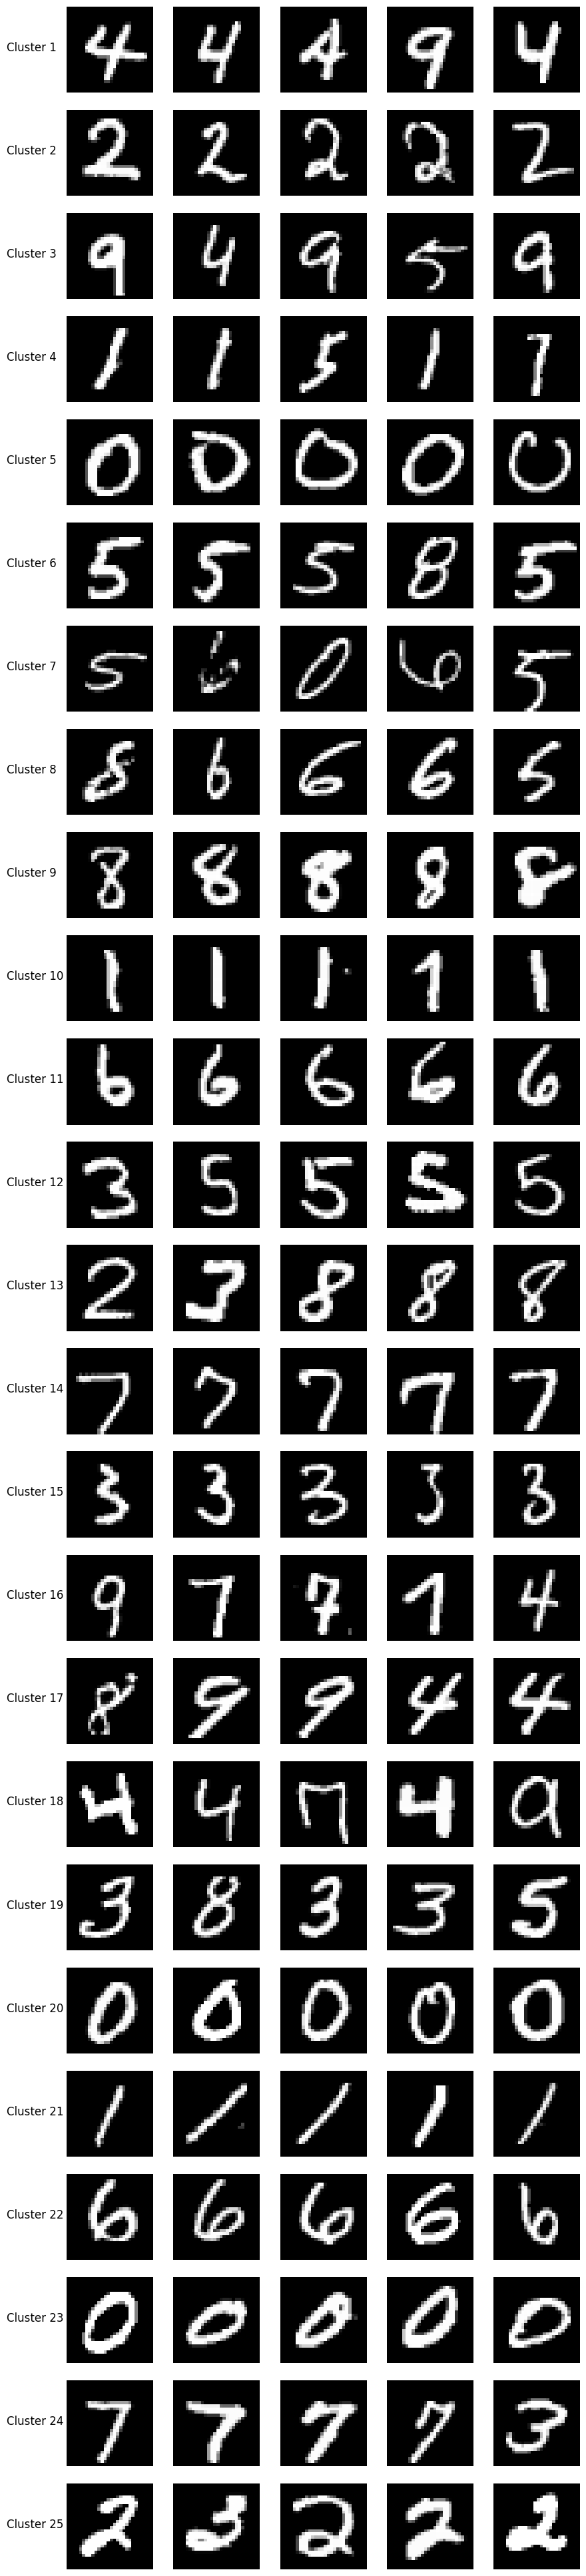

In [32]:
# 1. Retrain with the best parameters found above
best_params = best_results.iloc[0].to_dict()
# Remove scores from the dict to pass it into the model
del best_params['ari_score']
del best_params['hom_score']
del best_params['avg_score']

best_kmeans = KMeans(**best_params)
best_kmeans.fit(X_train_reduced)
cluster_labels = best_kmeans.predict(X_train_reduced)

fig, axes = plt.subplots(best_params['n_clusters'], 5, figsize=(10, 2 * best_params['n_clusters']))
for cluster_id in range(best_params['n_clusters']):
    # Find indices of all images assigned to this specific cluster
    indices = np.where(cluster_labels == cluster_id)[0]
    # Select random samples from this cluster (or the first 5)
    # We use a try/except in case a cluster has fewer than 5 items
    try:
        selected_indices = np.random.choice(indices, 5, replace=False)
    except ValueError:
        selected_indices = indices[:5] # Take what is available
        
    for i, idx in enumerate(selected_indices):
        ax = axes[cluster_id, i]
        
        # Reshape the original flat pixel vector (784,) into a 28x28 image
        image = X_train[idx].reshape(28, 28)
        
        ax.imshow(image, cmap='gray')
        ax.axis('off')
        
        # Label the first image of each row with the Cluster ID
        if i == 0:
            ax.text(-20, 14, f"Cluster {cluster_id + 1}", fontsize=12)

plt.show()

### Gaussian Mixture Model
#### Choosing hyperparameters

In [33]:
from sklearn.mixture import GaussianMixture
from sklearn.metrics import adjusted_rand_score, homogeneity_score
from sklearn.model_selection import ParameterGrid
import pandas as pd
import numpy as np

param_grid = {
    # 'n_components': [10, 15, 20, 25, 30], 
    'n_components': [10, 20, 30],
    # 'covariance_type': ['full', 'tied', 'diag', 'spherical']
    'covariance_type': ['diag']
}
results = []

# 2. Iterate through every combination
# We use a subset for scoring speed, but fit on the whole train set
sample_size = 5000 
X_test_sample = X_test_reduced[:sample_size] # Use test set or subset of train for validation
y_test_sample = y_test[:sample_size]

print(f"Starting Grid Search with {len(ParameterGrid(param_grid))} combinations...")

for params in ParameterGrid(param_grid):
    
    # Initialize and Fit
    gmm = GaussianMixture(**params)
    gmm.fit(X_train_reduced)

    
    # Note: Expensive calculation, so we use a sample.
    y_pred = gmm.predict(X_test_sample)
    ari_score = adjusted_rand_score(y_test_sample, y_pred)
    hom_score = homogeneity_score(y_test_sample, y_pred)
    avg_score = (hom_score + ari_score) / 2
    
    # Store results
    result_entry = params.copy()
    result_entry['ari_score'] = ari_score
    result_entry['hom_score'] = hom_score
    result_entry['avg_score'] = avg_score
    results.append(result_entry)
    
    print(f"Finished params: {params} | Adjusted Rand Score: {ari_score:.2f} | Homogeneity Score {hom_score:.2f} | Average Score {avg_score:.2f}")

# 4. Convert to DataFrame for easy analysis
results_df = pd.DataFrame(results)

# Sort by Silhouette Score (descending)
best_results = results_df.sort_values(by='avg_score', ascending=False)

print("\n--- Top 5 Configurations ---")
print(best_results.head(5))

Starting Grid Search with 3 combinations...
Finished params: {'covariance_type': 'diag', 'n_components': 10} | Adjusted Rand Score: 0.23 | Homogeneity Score 0.44 | Average Score 0.34


KeyboardInterrupt: 

#### Visualising results

Since I used PCA, I use `pca.inverse_transform` to turn the 200-dimension centroids back into 784-dimension (28x28) images.

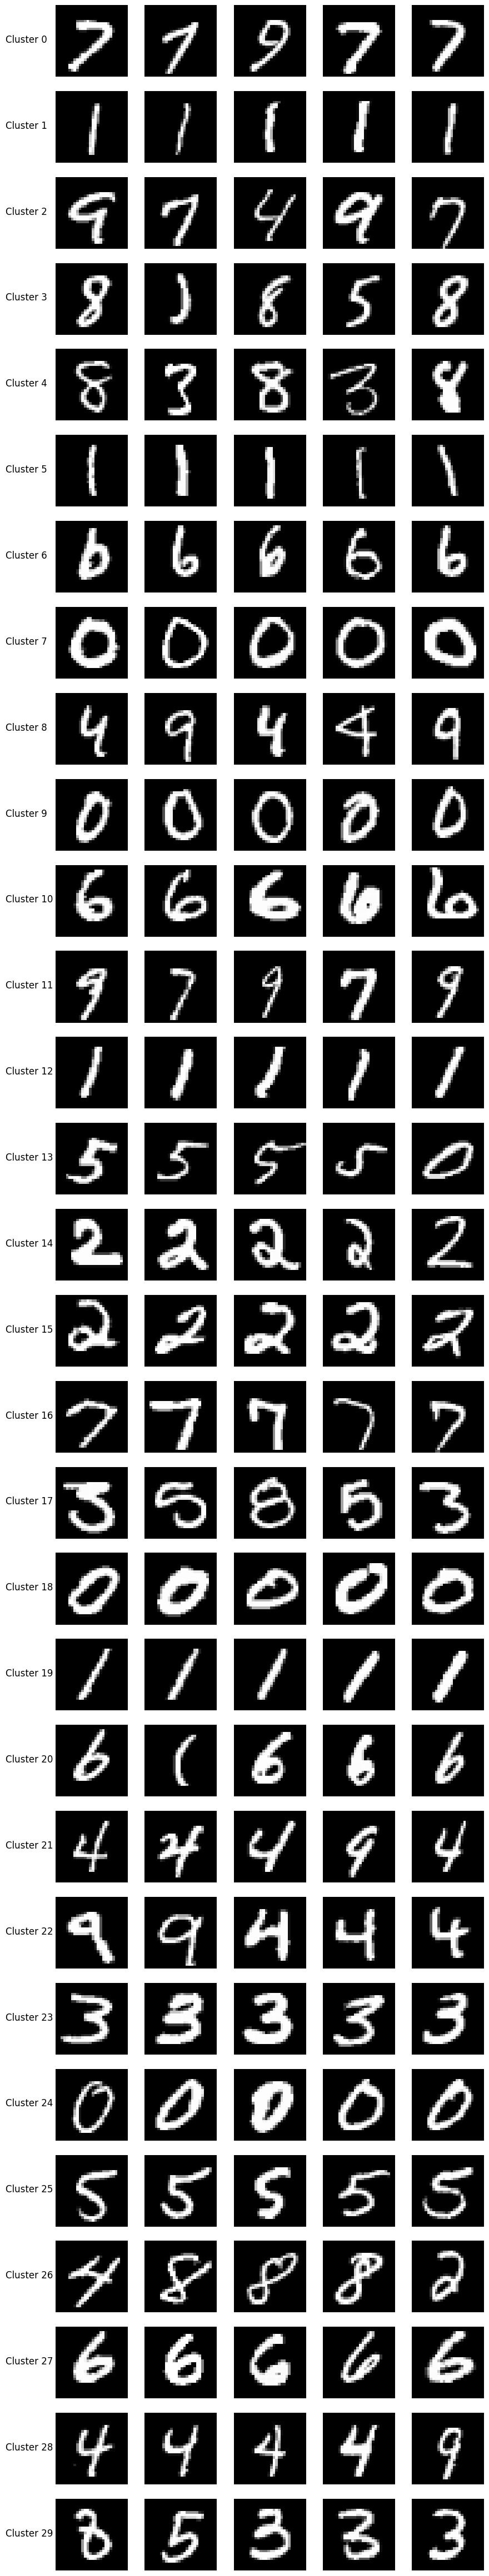

In [ ]:
# 1. Retrain with the best parameters found above
best_params = best_results.iloc[0].to_dict()
# Remove scores from the dict to pass it into the model
del best_params['ari_score']
del best_params['hom_score']
del best_params['avg_score']

best_gmm = GaussianMixture(**best_params)
best_gmm.fit(X_train_reduced)
cluster_labels = best_gmm.predict(X_train_reduced)

fig, axes = plt.subplots(best_params['n_components'], 5, figsize=(10, 2 * best_params['n_components']))
for cluster_id in range(best_params['n_components']):
    # Find indices of all images assigned to this specific cluster
    indices = np.where(cluster_labels == cluster_id)[0]
    # Select random samples from this cluster (or the first 5)
    # We use a try/except in case a cluster has fewer than 5 items
    try:
        selected_indices = np.random.choice(indices, 5, replace=False)
    except ValueError:
        selected_indices = indices[:5] # Take what is available
        
    for i, idx in enumerate(selected_indices):
        ax = axes[cluster_id, i]
        
        # Reshape the original flat pixel vector (784,) into a 28x28 image
        image = X_train[idx].reshape(28, 28)
        
        ax.imshow(image, cmap='gray')
        ax.axis('off')
        
        # Label the first image of each row with the Cluster ID
        if i == 0:
            ax.text(-20, 14, f"Cluster {cluster_id + 1}", fontsize=12)

plt.show()

### 3\. Key Hyperparameters Explained

  * **`n_clusters`**: Don't restrict yourself to exactly 10. In unsupervised learning on MNIST, it is common to find 12–25 clusters. For example, a "2" written with a loop and a "2" written as a Z-shape might form two distinct, valid clusters.
  * **`init`**:
      * `'k-means++'`: Selects initial cluster centers for k-mean clustering in a smart way to speed up convergence. Usually the best choice.
      * `'random'`: Chooses K observations (rows) at random from data for the initial centroids.
  * **`n_init`**: K-Means is sensitive to where it starts. If it starts in a "bad" spot, it might get stuck in a local minimum. `n_init` defines how many times the algorithm runs with different random starting points. It then picks the one with the lowest inertia. Increasing this improves stability but increases runtime.
  * **`tol`**: The tolerance regarding changes in the within-cluster sum-of-squares to declare convergence. If the model isn't changing much between iterations, it stops. Lowering this forces the model to be more precise.